# Capstone Project – The Battle of Neighborhoods 
#Finding a Better Place in North York, Toronto

In [512]:
!pip install geocoder
!pip install folium
!pip install sklearn

#Installing and Importing all required Libraries and Dependencies

In [513]:
import requests
import pandas as pd
import numpy as np
import json

import geocoder
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

import xml
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from geopy.geocoders import Nominatim 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from six import string_types


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Same data is used from CSV file made in last project with langitude and longitude, 'Canada.csv' with List of Postal Codes of Given Wikipedia Page.

In [514]:
df = pd.read_csv('Canada.csv')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188


Extracting North York data from current Canada dataframe and making new 'North York.csv' from it

In [515]:
north_york = df.loc[df.Borough=='North York']
north_york.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
7,M3B,North York,Don Mills North,43.74923,-79.36186
10,M6B,North York,Glencairn,43.70687,-79.44812


In [516]:
north_york.to_csv('North York.csv',index=False)

df_2 = pd.read_csv('North York.csv')
df_2.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
3,M3B,North York,Don Mills North,43.74923,-79.36186
4,M6B,North York,Glencairn,43.70687,-79.44812


Map of North York

In [517]:
location = geolocator.geocode('North York')
latitude = location.latitude
longitude = location.longitude

In [518]:
map_northyork = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_csv=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_northyork)  
    
map_northyork

Foursquare API Location Provider

In [519]:
CLIENT_ID = 'CGIG0OZM3EF3AOSKGXZ2KGL555Z4IT1YPBF0WMFIB0J0BCGY' # my Foursquare ID
CLIENT_SECRET = 'ROP4EQWEXY4JZJ1U0ZDR1R0J5W01TDH4JZYJWJHIF0Q4J2FX' # my Foursquare Secret
VERSION = '20210501'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: CGIG0OZM3EF3AOSKGXZ2KGL555Z4IT1YPBF0WMFIB0J0BCGY
CLIENT_SECRET: ROP4EQWEXY4JZJ1U0ZDR1R0J5W01TDH4JZYJWJHIF0Q4J2FX


In [520]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [521]:
venues = results['response']['groups'][0]['items']
nearby = json_normalize(venues)
nearby.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [522]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Nearby venues or locations of the area (North York) it is with 100 meter limit

In [523]:
filtered_column = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby =nearby.loc[:, filtered_column]
nearby.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
2,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
3,Domino's Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.753127,-79.450926


 Categories of nearby venues or locations

In [524]:
nearby['venue.categories'] = nearby.apply(get_category_type, axis=1)

# clean columns
nearby.columns = [col.split(".")[-1] for col in nearby.columns]

nearby.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Tim Hortons,Coffee Shop,43.754767,-79.443250
2,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
3,Domino's Pizza,Pizza Place,43.753127,-79.450926


Top 5 venue categories

In [525]:
a=pd.Series(nearby.categories)
a.value_counts()[:5]

Coffee Shop                  1
Pizza Place                  1
Mediterranean Restaurant     1
Middle Eastern Restaurant    1
Name: categories, dtype: int64

In [526]:
def get_Venues(names, latitudes, longitudes, radius=00):
    
    venue_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venue_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for list in venue_list for item in list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [529]:
NorthYork_venues = get_Venues(names = df_2['Neighborhood'],
                            latitudes = df_2['Latitude'],
                            longitudes = df_2['Longitude']
                             )

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills North
Glencairn
Don Mills South
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview East
York Mills, Silver Hills
Downsview West
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview Central
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale South
Downsview Northwest
York Mills West
Willowdale West


ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

In [530]:
print('There are {} Uniques Categories.'.format(len(NorthYork_venues['Venue Category'].unique())))
NorthYork_venues.groupby('Neighborhood').count().head()

There are 261 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,14,14,14,14,14,14
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Wilson Heights, Downsview North",1,1,1,1,1,1
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",21,21,21,21,21,21


Analyze Each Neighborhood

In [531]:
# one hot encoding
NY_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]

NY_onehot.head()


,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [532]:
NY_onehot.shape

(2368, 261)

let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [533]:
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

New size with  the mean of the frequency 

In [534]:
NY_grouped.shape

(101, 261)

Let's find out each neighborhood along with the top 5 most common venues

In [535]:
top_venues = 5

for hood in NY_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NY_grouped[NY_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.14
1  Hong Kong Restaurant  0.07
2         Grocery Store  0.07
3          Skating Rink  0.07
4         Shopping Mall  0.07


----Alderwood, Long Branch----
                   venue  freq
0                    Pub  0.25
1  Performing Arts Venue  0.25
2      Convenience Store  0.25
3                    Gym  0.25
4            Yoga Studio  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                      venue  freq
0               Men's Store   1.0
1               Yoga Studio   0.0
2       Martial Arts School   0.0
3            Mattress Store   0.0
4  Mediterranean Restaurant   0.0


----Bayview Village----
                        venue  freq
0                       Trail  0.50
1  Construction & Landscaping  0.25
2                        Park  0.25
3                 Yoga Studio  0.00
4          Miscellaneous Shop  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0 

           venue  freq
0    Pizza Place   0.2
1  Jewelry Store   0.2
2       Bus Line   0.2
3       Bus Stop   0.2
4    Music Venue   0.2


----Lawrence Manor, Lawrence Heights----
                    venue  freq
0          Clothing Store  0.22
1  Furniture / Home Store  0.06
2           Women's Store  0.04
3        Toy / Game Store  0.04
4          Cosmetics Shop  0.04


----Lawrence Park----
                      venue  freq
0                  Bus Line   0.5
1               Swim School   0.5
2               Yoga Studio   0.0
3                    Museum   0.0
4  Mediterranean Restaurant   0.0


----Leaside----
                    venue  freq
0             Coffee Shop  0.09
1  Furniture / Home Store  0.09
2     Sporting Goods Shop  0.06
3            Burger Joint  0.06
4                    Bank  0.06


----Little Portugal, Trinity----
                   venue  freq
0           Cocktail Bar  0.07
1                    Bar  0.07
2  Vietnamese Restaurant  0.05
3       Asian Restaurant  0.05

 Below, there is a function to sort the venues in descending order

In [536]:
def most_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

Let's create the new dataframe and display the top 10 venues for each neighborhood

In [537]:
top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues

columns = ['Neighborhood']

for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe

NB_venues_sorted = pd.DataFrame(columns=columns)
NB_venues_sorted['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    NB_venues_sorted.iloc[ind, 1:] = most_common_venues(NY_grouped.iloc[ind, :], top_venues)

NB_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Badminton Court,Hong Kong Restaurant,Shopping Mall,Bubble Tea Shop,Supermarket,Sushi Restaurant,Discount Store,Bakery,Department Store
1,"Alderwood, Long Branch",Performing Arts Venue,Gym,Convenience Store,Pub,Women's Store,Dry Cleaner,Distribution Center,Doctor's Office,Dog Run,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Men's Store,Women's Store,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
3,Bayview Village,Trail,Park,Construction & Landscaping,Women's Store,Dumpling Restaurant,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Thai Restaurant,Greek Restaurant,Pharmacy,Pub,Café,Butcher,Restaurant


K-Means Clustering Algorithm<br>
cluster the neighborhood into 5 clusters

In [566]:
# set number of clusters
kclusters = 5

NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 0, 1, 1, 1, 1, 1, 1])

a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [580]:
#NB_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NY_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(NB_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NY_merged# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,0,Food & Drink Shop,Park,Women's Store,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
1,M4A,North York,Victoria Village,43.73057,-79.31306,0,Pharmacy,Park,Grocery Store,German Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dessert Shop
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,1,Clothing Store,Furniture / Home Store,Women's Store,American Restaurant,Bookstore,Men's Store,Food Court,Cosmetics Shop,Toy / Game Store,Pharmacy
3,M3B,North York,Don Mills North,43.74923,-79.36186,1,Park,Soccer Field,Coffee Shop,Gas Station,Burger Joint,Women's Store,Dumpling Restaurant,Doctor's Office,Dog Run,Donut Shop
4,M6B,North York,Glencairn,43.70687,-79.44812,1,Grocery Store,Pizza Place,Bank,Gas Station,Fast Food Restaurant,Japanese Restaurant,Mediterranean Restaurant,Latin American Restaurant,Bakery,Doctor's Office
5,M3C,North York,Don Mills South,43.72168,-79.34352,1,Gym,Grocery Store,Intersection,Coffee Shop,Bubble Tea Shop,Supermarket,Women's Store,Dry Cleaner,Doctor's Office,Dog Run
6,M2H,North York,Hillcrest Village,43.80225,-79.35558,0,Park,Residential Building (Apartment / Condo),Women's Store,Dumpling Restaurant,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant
7,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.75788,-79.44847,4,Men's Store,Women's Store,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
8,M2J,North York,"Fairview, Henry Farm, Oriole",43.78097,-79.34781,1,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Women's Store,Juice Bar,Bank,Food Court,Jewelry Store,Skating Rink
9,M3J,North York,"Northwood Park, York University",43.76476,-79.48798,1,Furniture / Home Store,Automotive Shop,Massage Studio,Bar,Japanese Restaurant,Restaurant,Caribbean Restaurant,Falafel Restaurant,Fast Food Restaurant,Pizza Place


Map of clusters

In [568]:
kcluster = 10

# create map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NY_merged['Latitude'], 
                                   NY_merged['Longitude'], 
                                   NY_merged['Neighborhood'], 
                                   NY_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']


Examine Clusters

In [569]:
# Cluster 1
df1 = NY_merged.loc[NY_merged['Cluster Labels'] == 0, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,0,Food & Drink Shop,Park,Women's Store,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
1,North York,0,Pharmacy,Park,Grocery Store,German Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dessert Shop
6,North York,0,Park,Residential Building (Apartment / Condo),Women's Store,Dumpling Restaurant,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant
10,North York,0,Trail,Park,Construction & Landscaping,Women's Store,Dumpling Restaurant,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner
14,North York,0,Bakery,Park,Basketball Court,Women's Store,Eastern European Restaurant,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store


In [570]:
# Cluster 2
df2 = NY_merged.loc[NY_merged['Cluster Labels'] == 1, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,North York,1,Clothing Store,Furniture / Home Store,Women's Store,American Restaurant,Bookstore,Men's Store,Food Court,Cosmetics Shop,Toy / Game Store,Pharmacy
3,North York,1,Park,Soccer Field,Coffee Shop,Gas Station,Burger Joint,Women's Store,Dumpling Restaurant,Doctor's Office,Dog Run,Donut Shop
4,North York,1,Grocery Store,Pizza Place,Bank,Gas Station,Fast Food Restaurant,Japanese Restaurant,Mediterranean Restaurant,Latin American Restaurant,Bakery,Doctor's Office
5,North York,1,Gym,Grocery Store,Intersection,Coffee Shop,Bubble Tea Shop,Supermarket,Women's Store,Dry Cleaner,Doctor's Office,Dog Run
8,North York,1,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Women's Store,Juice Bar,Bank,Food Court,Jewelry Store,Skating Rink
9,North York,1,Furniture / Home Store,Automotive Shop,Massage Studio,Bar,Japanese Restaurant,Restaurant,Caribbean Restaurant,Falafel Restaurant,Fast Food Restaurant,Pizza Place
11,North York,1,Turkish Restaurant,Park,Latin American Restaurant,Italian Restaurant,Chinese Restaurant,Sandwich Place,Pizza Place,Vietnamese Restaurant,Bakery,Dumpling Restaurant
13,North York,1,Fast Food Restaurant,Hockey Arena,Bakery,Discount Store,Department Store,Beer Store,Pizza Place,Hotel,Coffee Shop,Convenience Store
15,North York,1,Business Service,Hobby Shop,Construction & Landscaping,Home Service,Women's Store,Eastern European Restaurant,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant


In [571]:
# Cluster 3
df3 = NY_merged.loc[NY_merged['Cluster Labels'] == 2, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df3

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [572]:
# Cluster 4
df4 = NY_merged.loc[NY_merged['Cluster Labels'] == 3, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,North York,3,Park,Women's Store,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [573]:
# Cluster 5
df5 = NY_merged.loc[NY_merged['Cluster Labels'] == 4, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]
df5

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,North York,4,Men's Store,Women's Store,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [574]:
data = pd.read_csv('neighbourhood-crime-rates.csv')

In [575]:
data.head()

,_id,OBJECTID,Neighbourhood,Hood_ID,F2020_Population_Projection,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_2020,Assault_Rate2014,Assault_Rate2015,Assault_Rate2016,Assault_Rate2017,Assault_Rate2018,Assault_Rate2019,Assault_Rate2020,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_2020,AutoTheft_Rate2014,AutoTheft_Rate2015,AutoTheft_Rate2016,AutoTheft_Rate2017,AutoTheft_Rate2018,AutoTheft_Rate2019,AutoTheft_Rate2020,BreakAndEnter_2014,BreakAndEnter_2015,BreakAndEnter_2016,BreakAndEnter_2017,BreakAndEnter_2018,BreakAndEnter_2019,BreakAndEnter_2020,BreakAndEnter_Rate2014,BreakAndEnter_Rate2015,BreakAndEnter_Rate2016,BreakAndEnter_Rate2017,BreakAndEnter_Rate2018,BreakAndEnter_Rate2019,BreakAndEnter_Rate2020,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_2020,Robbery_Rate2014,RobberyRate_2015,Robbery_Rate2016,Robbery_Rate2017,Robbery_Rate2018,Robbery_Rate2019,Robbery_Rate2020,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_2020,TheftOver_Rate2014,TheftOver_Rate2015,TheftOver_Rate2016,TheftOver_Rate2017,TheftOver_Rate2018,TheftOver_Rate2019,TheftOver_Rate2020,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_2020,Homicide_Rate2014,Homicide_Rate2015,Homicide_Rate2016,Homicide_Rate2017,Homicide_Rate2018,Homicide_Rate2019,Homicide_Rate2020,Shootings_2014,Shootings_2015,Shootings_2016,Shootings_2017,Shootings_2018,Shootings_2019,Shootings_2020,Shooting_Rate2014,Shootings_Rate2015,Shootings_Rate2016,Shootings_Rate2017,Shootings_Rate2018,Shootings_Rate2019,Shootings_Rate2020,geometry
0,1,1,Yonge-St.Clair,97,14083,16,25,34,25,28,35,23,127.0144,196.1246,262.5482,189.1790,207.2846,253.8071,163.3175,2,3,7,2,6,6,9,15.8768,23.53495,54.05405,15.13432,44.41812,43.50979,63.90684,37,20,12,18,24,28,26,293.7207,156.8997,92.66409,136.2088,177.6725,203.0457,184.6198,4,1,6,1,1,4,5,31.75359,7.844983,46.33205,7.567159,7.40302,29.00653,35.50380,3,5,7,0,3,6,3,23.81519,39.22491,54.05405,0.00000,22.20906,43.50979,21.30228,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,"{u'type': u'Polygon', u'coordinates': (((-79.3..."
1,2,2,York University Heights,27,30277,273,298,363,351,362,382,341,950.5571,1041.4850,1269.3200,1211.0970,1230.3300,1279.8610,1126.2670,106,100,106,89,91,147,184,369.0808,349.49150,370.65530,307.08720,309.28190,492.51180,607.72200,108,140,98,105,122,111,105,376.0446,489.2881,342.68130,362.2938,414.6416,371.8967,346.7979,58,85,70,76,94,84,47,201.94990,297.067800,244.77240,262.231700,319.47800,281.43530,155.23340,30,46,38,40,38,31,43,104.45680,160.76610,132.87640,138.01670,129.15070,103.86300,142.02200,1,0,2,0,1,0,1,3.481894,0.000000,6.993496,0.000000,0.000000,0.000000,3.302837,2,0,4,10,8,6,12,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,"{u'type': u'Polygon', u'coordinates': (((-79.5..."
2,3,3,Lansing-Westgate,38,18146,42,81,67,84,68,70,97,261.0966,494.6263,400.6698,492.5531,390.1543,393.5901,534.5530,17,22,26,26,16,30,44,105.6820,134.34290,155.48380,152.45690,91.80102,168.68150,242.47770,34,27,41,42,50,39,39,211.3639,164.8754,245.18600,246.2765,286.8782,219.2859,214.9234,12,6,6,14,32,12,11,74.59903,36.638980,35.88087,82.092180,183.60200,67.47259,60.61942,4,5,5,11,6,10,9,24.86634,30.53249,29.90073,64.50100,34.42538,56.22716,49.59771,0,0,0,0,10,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,1,2,1,0.000000,0.000000,5.980146,0.000000,5.737564,11.245430,5.510856,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
3,4,4,Yorkdale-Glen Park,31,17560,106,137,175,163,178,210,156,697.5061,902.0279,1149.1990,1031.8410,1086.5580,1237.4050,888.3827,63,53,41,54,64,64,87,414.5555,348.95970,269.24090,341.83710,390.67270,377.11390,495.44420,51,57,66,62,67,90,81,335.5926,375.2963,433.4

In [548]:
crime_data = data.groupby(['F2020_Population_Projection','BreakAndEnter_Rate2020','Robbery_Rate2020','Shootings_Rate2020'])['Neighbourhood'].apply(', '.join).reset_index()

In [549]:
crime_data.head()

,F2020_Population_Projection,BreakAndEnter_Rate2020,Robbery_Rate2020,Shootings_Rate2020,Neighbourhood
0,7130,98.17672,56.10098,0.00000,Beechborough-Greenbrook
1,8257,605.54680,96.88749,12.11094,Playter Estates-Danforth
2,8287,337.87860,48.26837,24.13419,Blake-Jones
3,8309,144.42170,72.21085,0.00000,Woodbine-Lumsden
4,8433,154.15630,11.85818,0.00000,Lambton Baby Point


In [550]:
crime_data.describe()

,F2020_Population_Projection,BreakAndEnter_Rate2020,Robbery_Rate2020,Shootings_Rate2020
count,140.000000,140.000000,140.000000,140.000000
mean,21728.871429,227.141766,87.841717,14.426955
std,11839.460093,152.359108,64.799312,17.827221
min,7130.000000,28.092520,7.132668,0.000000
25%,13227.250000,122.144325,50.666290,0.000000
50%,18378.000000,191.495550,76.242040,7.677692
75%,26598.250000,285.583975,112.382175,21.048253
max,87808.000000,840.828300,543.819300,102.933600


In [551]:
crime_data.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
crime_data.set_index('Neighborhood',inplace=True,drop=True)
crime_data.head()

,F2020_Population_Projection,BreakAndEnter_Rate2020,Robbery_Rate2020,Shootings_Rate2020
Neighborhood,,,,
Beechborough-Greenbrook,7130,98.17672,56.10098,0.00000
Playter Estates-Danforth,8257,605.54680,96.88749,12.11094
Blake-Jones,8287,337.87860,48.26837,24.13419
Woodbine-Lumsden,8309,144.42170,72.21085,0.00000
Lambton Baby Point,8433,154.15630,11.85818,0.00000


Text(0.5, 1.0, 'Visualization of Break and Enter rate of 2020 in North York')

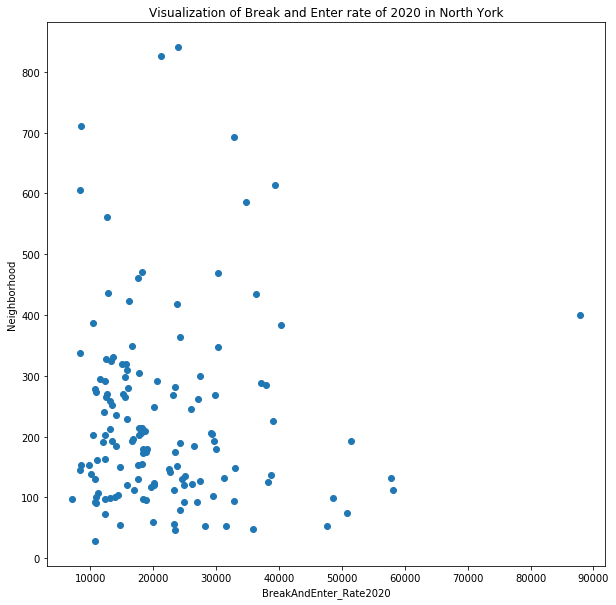

In [595]:
#crime_data['BreakAndEnter_2020'].plot(kind='bar',figsize=(24,18),alpha=0.75)

plt.figure(figsize=(10, 10))
plt.scatter(crime_data.iloc[:, 0], crime_data.iloc[:, 1])
plt.xlabel('BreakAndEnter_Rate2020')
plt.ylabel('Neighborhood')
plt.title('Visualization of Break and Enter rate of 2020 in North York')

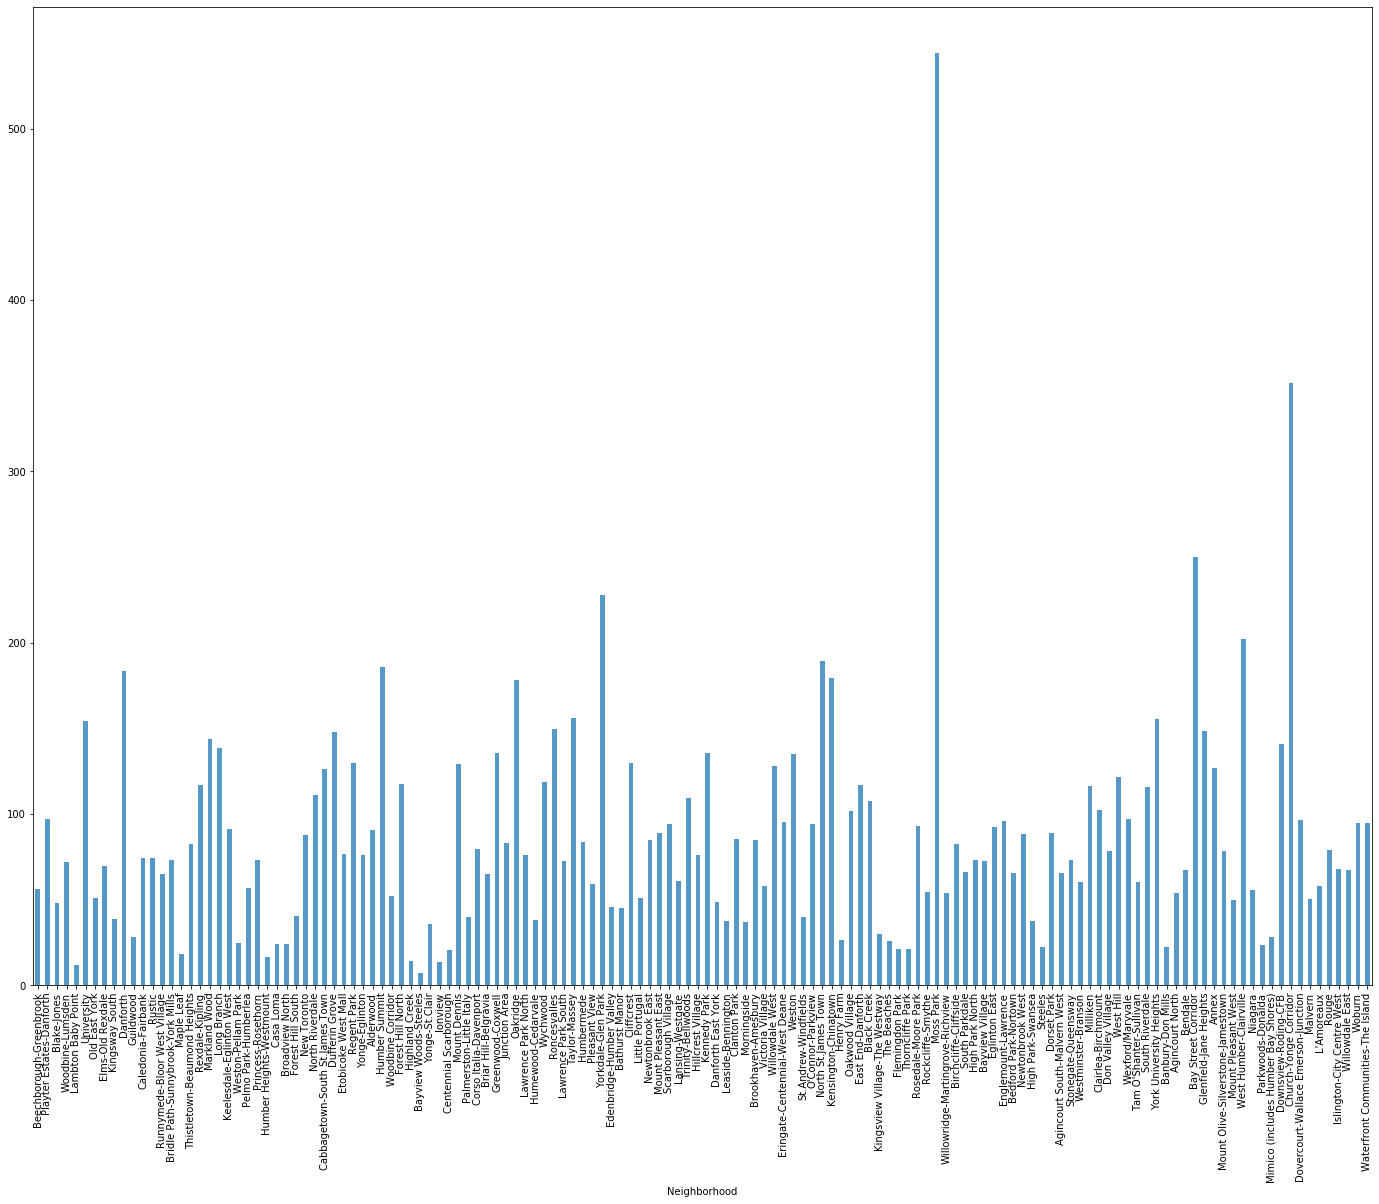

In [555]:
crime_data['Robbery_Rate2020'].plot(kind='bar',figsize=(24,18),alpha=0.75)

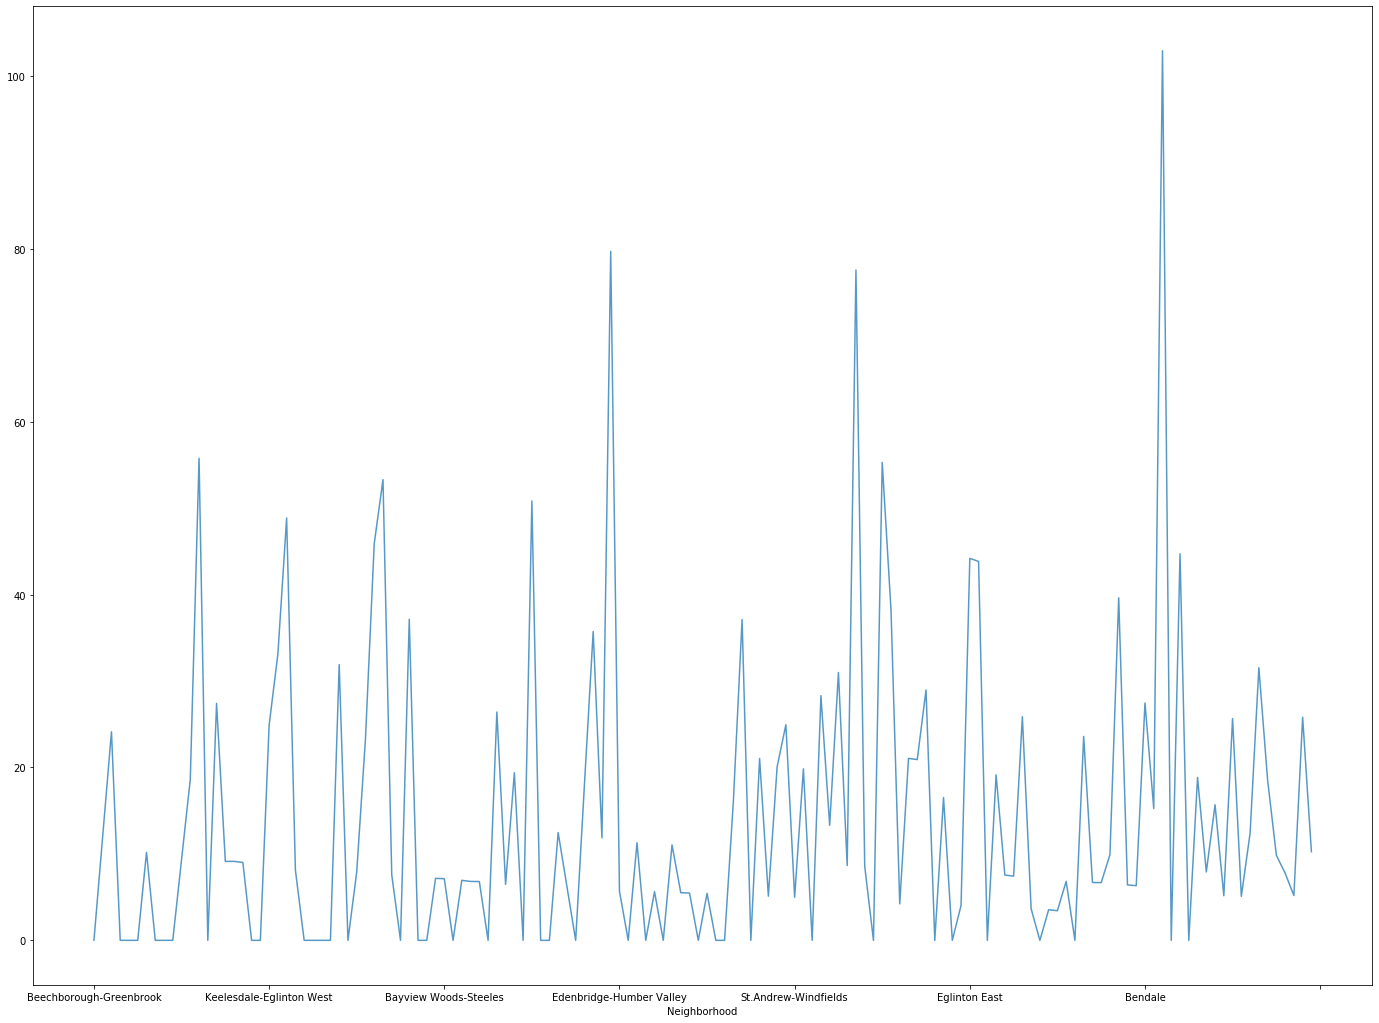

In [558]:
crime_data['Shootings_Rate2020'].plot(kind='line',figsize=(24,18),alpha=0.75)

Making crime data focused on North York's neighborhood

In [559]:
df_data = pd.merge(df_2, crime_data, on='Neighborhood')
df_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude,F2020_Population_Projection,BreakAndEnter_Rate2020,Robbery_Rate2020,Shootings_Rate2020
0,M4A,North York,Victoria Village,43.73057,-79.31306,19005,178.90030,57.87951,21.047090
1,M2H,North York,Hillcrest Village,43.80225,-79.35558,18349,98.09799,76.29844,0.000000
2,M2K,North York,Bayview Village,43.78112,-79.38060,24799,120.97260,72.58357,4.032421
3,M9L,North York,Humber Summit,43.75948,-79.55707,13458,193.19360,185.76310,37.152620
4,M2R,North York,Willowdale West,43.77989,-79.44678,19571,117.52080,127.74000,5.109601


In [560]:
df_data.describe()


,Latitude,Longitude,F2020_Population_Projection,BreakAndEnter_Rate2020,Robbery_Rate2020,Shootings_Rate2020
count,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000
mean,43.770662,-79.410618,19036.40000,141.737058,104.052924,13.468346
std,0.027040,0.095136,4033.77637,41.685850,52.749991,15.481310
min,43.730570,-79.557070,13458.00000,98.097990,57.879510,0.000000
25%,43.759480,-79.446780,18349.00000,117.520800,72.583570,4.032421
50%,43.779890,-79.380600,19005.00000,120.972600,76.298440,5.109601
75%,43.781120,-79.355580,19571.00000,178.900300,127.740000,21.047090
max,43.802250,-79.313060,24799.00000,193.193600,185.763100,37.152620


These five neighbourhood has high crime rate in North york, so I would suggest not to live in these areas.

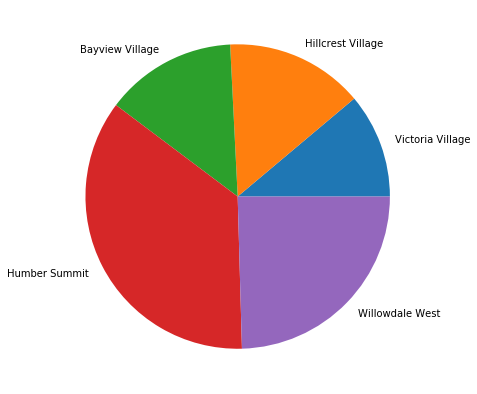

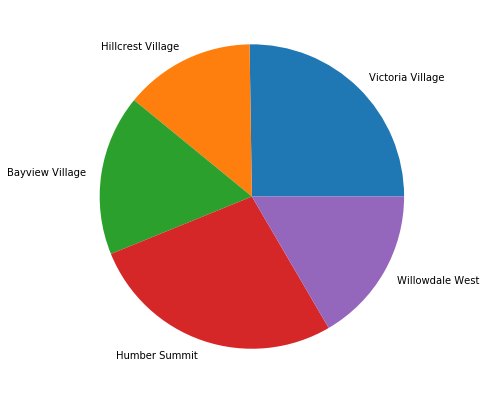

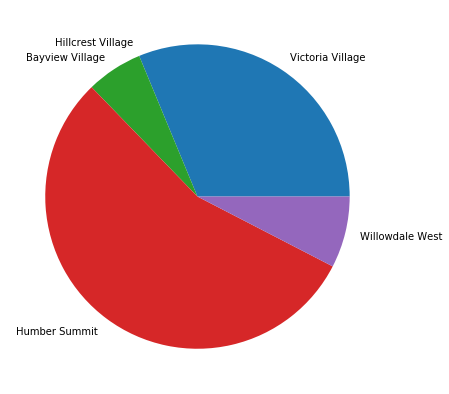

In [561]:
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(df_data['Robbery_Rate2020'], labels = df_data['Neighborhood'])

# show plot
plt.show()

fig = plt.figure(figsize =(10, 7))
plt.pie(df_data['BreakAndEnter_Rate2020'], labels = df_data['Neighborhood'])

# show plot
plt.show()

fig = plt.figure(figsize =(10, 7))
plt.pie(df_data['Shootings_Rate2020'], labels = df_data['Neighborhood'])
  
# show plot
plt.show()